In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

train_df = pd.read_csv('../laliga.csv')

train_df["local_score"] = train_df["score"].str.split(":").str[0]
train_df["away_score"] = train_df["score"].str.split(":").str[1]
train_df['results'] = train_df.apply(lambda row: 1 if row['local_score'] > row['away_score'] else (2 if row['away_score'] > row['local_score'] else ('X' if row['local_score'] == row['away_score'] else None)), axis=1)
train_df['results_encoded'] = train_df.apply(lambda row: 1 if row['results'] == 1 else (3 if row['results'] == 2 else (2 if row['results'] == 'X' else None)), axis=1)

train_df = train_df.dropna(subset=['local_score'])
train_df = train_df.dropna(subset=['away_score'])
train_df['local_score'] = train_df['local_score'].astype(int)
train_df['away_score'] = train_df['away_score'].astype(int)
train_df['goal_diff'] = train_df['local_score'] - train_df['away_score']
train_df['abs_goal_diff'] = np.abs(train_df['goal_diff'])


In [95]:
Elo_table = pd.DataFrame()
Elo_table['Team'] = train_df['home_team'].unique()
Elo_table['ELO'] = 1000

train_df['Local_Elo'] = 0
train_df['Away_Elo'] = 0
train_df['Elo_diff'] = 0

In [96]:
team_id = pd.DataFrame()
team_id['Team'] = train_df['home_team'].unique()
team_id['Id'] = team_id.index

In [97]:
def ELO_score(row):
    global Elo_table, team_id
    row['Local_Elo'] = local_elo = Elo_table.loc[Elo_table['Team'] == row['home_team'], 'ELO'].values[0]
    row['Away_Elo'] = away_elo = Elo_table.loc[Elo_table['Team'] == row['away_team'], 'ELO'].values[0]
    row['Elo_diff'] = row['Local_Elo'] - row['Away_Elo']
    row['Local_id'] = team_id.loc[team_id['Team'] == row['home_team'], 'Id'].values[0]
    row['Away_id'] = team_id.loc[team_id['Team'] == row['away_team'], 'Id'].values[0]

    expected_local = 1/(1+10**((away_elo - local_elo)/400))
    expected_away = 1/(1+10**((local_elo - away_elo)/400))

    if row['results'] == 1:
        result_local = 1
        result_away = 0
    elif row['results'] == 2:
        result_local = 0
        result_away = 1
    else:
        result_local = 0.5
        result_away = 0.5

    K = 30

    Elo_table.loc[Elo_table['Team'] == row['home_team'], 'ELO'] = local_elo + K*(result_local - expected_local)/row['division']
    Elo_table.loc[Elo_table['Team'] == row['away_team'], 'ELO'] = away_elo + K*(result_away - expected_away)/row['division']
    return row

In [98]:
train_df = train_df.apply(lambda row: ELO_score(row), axis = 1)
top_elo = Elo_table.sort_values(by='ELO', ascending=False).head(10).reset_index(drop=True)
top_elo

C:\Users\raulh\AppData\Local\Temp\ipykernel_11688\2578832382.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1015.6471999915343' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Elo_table.loc[Elo_table['Team'] == row['home_team'], 'ELO'] = local_elo + K*(result_local - expected_local)/row['division']


,Team,ELO
0,Real Madrid,1340.098247
1,Barcelona,1283.247835
2,Ath. Aviación,1188.541855
3,Atlético Madrid,1186.422712
4,CA Osasuna,1159.239349
5,Real Betis,1153.518628
6,Sevilla FC,1151.599784
7,RCD Mallorca,1149.368635
8,Real Sociedad,1133.578834
9,Villarreal,1128.449952


In [100]:
train_df.to_excel('../data/modeldata.xlsx')
Elo_table.to_excel('../data/ELOtable.xlsx')

In [8]:
df = pd.read_excel('../data/modeldata.xlsx')
q10 = pd.read_excel('../reports/MatchdayStandings.xlsx')
df['Local_Rank'] = 0
df['Away_Rank'] = 0

In [65]:
def assing_current_rank(row):
    row['Local_Rank'] = q10.loc[(q10['Season'] == row['season']) & (q10['Matchday'] == row['matchday']) & (q10['Team'] == row['home_team']), 'Rank'].values[0]
    row['Away_Rank'] = q10.loc[(q10['Season'] == row['season']) & (q10['Matchday'] == row['matchday']) & (q10['Team'] == row['away_team']), 'Rank'].values[0]
    return row

In [66]:
df = df.apply(lambda row: assing_current_rank(row), axis=1)
df

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
df.to_excel('../data/modeldata.xlsx')

In [17]:
from sklearn.model_selection import train_test_split

df = pd.read_excel('../data/modeldata.xlsx')

In [15]:
features = [
    'Local_id',
    'Away_id',
    'Local_Elo',
    'Away_Elo',
    'Elo_diff',
    'division'
]

target = ['results_encoded']

In [18]:
X, y = df[features], df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Linear Regression

In [47]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [48]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred.astype(int)
results_df

,Local_id,Away_id,Local_Elo,Away_Elo,Elo_diff,division,y_real,y_pred
23629,2,35,1340.919364,972.786614,368.132750,1,1,0
43458,136,62,980.052854,1127.172305,-147.119451,2,1,2
45365,16,29,1022.174317,988.100109,34.074208,2,2,1
19839,40,18,1032.211075,1090.678719,-58.467644,1,1,1
10859,25,24,971.836582,1242.855196,-271.018614,1,3,2
...,...,...,...,...,...,...,...,...
27942,66,82,964.307932,979.209962,-14.902031,2,1,1
39450,93,44,967.704004,1062.983687,-95.279683,2,2,1
35036,25,118,1046.214534,991.114786,55.099748,2,1,1
42373,15,53,1092.708561,1006.739597,85.968964,2,1,1


In [49]:
correct_results = results_df[results_df['y_real'] == results_df['y_pred']]
percentage_correct = str(len(correct_results)*100/len(results_df)) + '%'
percentage_correct

'51.958333333333336%'

# Gradient Boosting Classifier

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train, y_train)
gbm_y_pred = gbm_model.predict(X_test)
probabilities = gbm_model.predict_proba(X_test)

        
prob_df = pd.DataFrame(probabilities, columns=[f'Result {i+1} Prob' for i in range(probabilities.shape[1])])

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = gbm_y_pred.astype(int)
results_df = results_df.merge(prob_df, left_index=True, right_index=True)
results_df

c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Local_id,Away_id,Local_Elo,Away_Elo,Elo_diff,division,y_real,y_pred,Result 1 Prob,Result 2 Prob,Result 3 Prob
2645,30,6,1125.292530,1056.090319,69.202211,1,2,1,0.534234,0.291651,0.174115
6531,43,39,1028.082761,1089.203160,-61.120399,1,2,1,0.669682,0.212613,0.117705
1169,24,11,936.708243,1121.529250,-184.821007,1,3,3,0.647247,0.233554,0.119199
3625,11,31,1134.941359,994.652476,140.288884,1,2,1,0.510722,0.274685,0.214593
8777,20,6,987.053516,1025.747323,-38.693807,1,3,1,0.289985,0.290616,0.419399
...,...,...,...,...,...,...,...,...,...,...,...
283,1,5,969.217676,1085.162819,-115.945142,1,3,1,0.422738,0.319917,0.257345
3025,2,5,1077.744707,1120.496119,-42.751412,1,1,1,0.815914,0.114064,0.070022
3621,1,23,1078.180884,1052.439389,25.741495,1,1,1,0.665595,0.187557,0.146849
5885,39,20,1121.745131,1047.770183,73.974948,1,1,1,0.566035,0.262707,0.171258


In [29]:
prob_df

,Result 1 Prob,Result 2 Prob,Result 3 Prob
0,0.898504,0.057250,0.044246
1,0.290504,0.285595,0.423901
2,0.618200,0.228755,0.153045
3,0.486639,0.299956,0.213406
4,0.228506,0.256550,0.514944
...,...,...,...
9595,0.660452,0.185918,0.153630
9596,0.356794,0.372657,0.270549
9597,0.556594,0.268575,0.174831
9598,0.603984,0.240822,0.155194


In [28]:
X_test

,Local_id,Away_id,Local_Elo,Away_Elo,Elo_diff,division
23629,2,35,1340.919364,972.786614,368.132750,1
43458,136,62,980.052854,1127.172305,-147.119451,2
45365,16,29,1022.174317,988.100109,34.074208,2
19839,40,18,1032.211075,1090.678719,-58.467644,1
10859,25,24,971.836582,1242.855196,-271.018614,1
...,...,...,...,...,...,...
27942,66,82,964.307932,979.209962,-14.902031,2
39450,93,44,967.704004,1062.983687,-95.279683,2
35036,25,118,1046.214534,991.114786,55.099748,2
42373,15,53,1092.708561,1006.739597,85.968964,2


In [30]:
correct_results = results_df[results_df['y_real'] == results_df['y_pred']]
percentage_correct = str(len(correct_results)*100/len(results_df)) + '%'
percentage_correct

'62.03937405350833%'

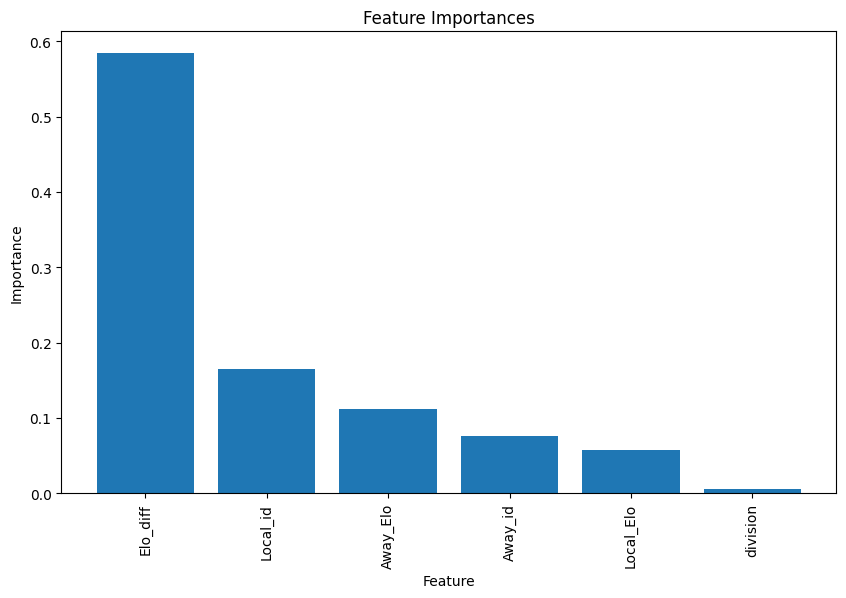

In [26]:
importances = gbm_model.feature_importances_

# Get the names of features
feature_names = X.columns  # Assuming X is a DataFrame

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

# GBC Tuning

In [135]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gbc_model = GradientBoostingClassifier(learning_rate=0.1, warm_start=True)

iterations = 10

for i in range(iterations):
    gbc_model.fit(X_train, y_train)
    gbc_y_pred = gbm_model.predict(X_test)
    accuracy = accuracy_score(y_test, gbc_y_pred)
    print('Accuracy in iteration '+str(i+1)+': '+str(accuracy))
    gbc_model.learning_rate += 0.1


c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy in iteration 1: 0.5328125
Accuracy in iteration 2: 0.5328125


c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy in iteration 3: 0.5328125
Accuracy in iteration 4: 0.5328125


c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy in iteration 5: 0.5328125


c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy in iteration 6: 0.5328125


c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy in iteration 7: 0.5328125


c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy in iteration 8: 0.5328125


c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy in iteration 9: 0.5328125


c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy in iteration 10: 0.5328125


# Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
gbm_model = RandomForestClassifier()
gbm_model.fit(X_train, y_train)
gbm_y_pred = gbm_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = gbm_y_pred.astype(int)
results_df

c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,Local_id,Away_id,Local_Elo,Away_Elo,Elo_diff,y_real,y_pred
16689,18,2,998.725129,1253.608174,-254.883045,1,1
2045,14,2,1112.936810,1155.073296,-42.136487,1,1
5000,14,30,1075.592855,1113.876460,-38.283604,1,2
18660,49,23,1104.867415,1155.829061,-50.961646,3,3
21816,44,11,934.378379,1176.876724,-242.498345,3,2
...,...,...,...,...,...,...,...
25056,2,12,1217.868106,1058.764776,159.103330,3,1
6174,35,12,1001.562662,1080.403105,-78.840443,2,1
25270,40,31,975.962913,1035.690819,-59.727906,3,2
24323,23,24,990.006064,1156.904984,-166.898920,3,1


In [11]:
correct_results = results_df[results_df['y_real'] == results_df['y_pred']]
percentage_correct = str(len(correct_results)*100/len(results_df)) + '%'
percentage_correct

'52.456479690522244%'

# Support Vector Classifier

In [12]:
from sklearn.svm import SVC 
gbm_model = SVC()
gbm_model.fit(X_train, y_train)
gbm_y_pred = gbm_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = gbm_y_pred.astype(int)
results_df

c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Local_id,Away_id,Local_Elo,Away_Elo,Elo_diff,y_real,y_pred
16689,18,2,998.725129,1253.608174,-254.883045,1,3
2045,14,2,1112.936810,1155.073296,-42.136487,1,1
5000,14,30,1075.592855,1113.876460,-38.283604,1,1
18660,49,23,1104.867415,1155.829061,-50.961646,3,1
21816,44,11,934.378379,1176.876724,-242.498345,3,1
...,...,...,...,...,...,...,...
25056,2,12,1217.868106,1058.764776,159.103330,3,1
6174,35,12,1001.562662,1080.403105,-78.840443,2,1
25270,40,31,975.962913,1035.690819,-59.727906,3,1
24323,23,24,990.006064,1156.904984,-166.898920,3,1


In [13]:
correct_results = results_df[results_df['y_real'] == results_df['y_pred']]
percentage_correct = str(len(correct_results)*100/len(results_df)) + '%'
percentage_correct

'56.479690522243715%'

# K-Nearest Neighbors

In [14]:
from sklearn.neighbors import KNeighborsClassifier
gbm_model = KNeighborsClassifier()
gbm_model.fit(X_train, y_train)
gbm_y_pred = gbm_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = gbm_y_pred.astype(int)
results_df

c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


,Local_id,Away_id,Local_Elo,Away_Elo,Elo_diff,y_real,y_pred
16689,18,2,998.725129,1253.608174,-254.883045,1,1
2045,14,2,1112.936810,1155.073296,-42.136487,1,1
5000,14,30,1075.592855,1113.876460,-38.283604,1,2
18660,49,23,1104.867415,1155.829061,-50.961646,3,1
21816,44,11,934.378379,1176.876724,-242.498345,3,2
...,...,...,...,...,...,...,...
25056,2,12,1217.868106,1058.764776,159.103330,3,2
6174,35,12,1001.562662,1080.403105,-78.840443,2,1
25270,40,31,975.962913,1035.690819,-59.727906,3,1
24323,23,24,990.006064,1156.904984,-166.898920,3,1


In [15]:
correct_results = results_df[results_df['y_real'] == results_df['y_pred']]
percentage_correct = str(len(correct_results)*100/len(results_df)) + '%'
percentage_correct

'50.75435203094778%'

# Decision Tree Classifier

In [126]:
from sklearn.tree import DecisionTreeClassifier
gbm_model = DecisionTreeClassifier()
gbm_model.fit(X_train, y_train)
gbm_y_pred = gbm_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = gbm_y_pred.astype(int)
results_df

,Local_id,Away_id,Local_Elo,Away_Elo,Elo_diff,y_real,y_pred
23629,2,35,1340.919364,972.786614,368.132750,1,1
43458,136,62,980.052854,1127.172305,-147.119451,1,3
45365,16,29,1022.174317,988.100109,34.074208,2,3
19839,40,18,1032.211075,1090.678719,-58.467644,1,1
10859,25,24,971.836582,1242.855196,-271.018614,3,2
...,...,...,...,...,...,...,...
27942,66,82,964.307932,979.209962,-14.902031,1,1
39450,93,44,967.704004,1062.983687,-95.279683,2,1
35036,25,118,1046.214534,991.114786,55.099748,1,2
42373,15,53,1092.708561,1006.739597,85.968964,1,1


In [127]:
correct_results = results_df[results_df['y_real'] == results_df['y_pred']]
percentage_correct = str(len(correct_results)*100/len(results_df)) + '%'
percentage_correct

'41.302083333333336%'

# CatBoostClassifier

In [53]:
from catboost import CatBoostClassifier
params = {
    'iterations': 300,
    'learning_rate': 0.01,
    'depth': 8,
}
model = CatBoostClassifier(**params)
categorical_features = ['Local_id', 'Away_id']
model.fit(X_train, y_train, cat_features=categorical_features)
# Make predictions
predictions = model.predict(X_test)


catboost_result = X_test.copy()
catboost_result["y_real"] = y_test
catboost_result["y_pred"] = predictions.astype(int)
catboost_result

0:	learn: 1.0962554	total: 104ms	remaining: 31.2s
1:	learn: 1.0940044	total: 160ms	remaining: 23.8s
2:	learn: 1.0917407	total: 244ms	remaining: 24.2s
3:	learn: 1.0895426	total: 329ms	remaining: 24.4s
4:	learn: 1.0873969	total: 437ms	remaining: 25.8s
5:	learn: 1.0853360	total: 531ms	remaining: 26s
6:	learn: 1.0832686	total: 658ms	remaining: 27.6s
7:	learn: 1.0812444	total: 800ms	remaining: 29.2s
8:	learn: 1.0793096	total: 923ms	remaining: 29.8s
9:	learn: 1.0773891	total: 1.07s	remaining: 31s
10:	learn: 1.0756217	total: 1.13s	remaining: 29.8s
11:	learn: 1.0737980	total: 1.26s	remaining: 30.3s
12:	learn: 1.0720099	total: 1.39s	remaining: 30.7s
13:	learn: 1.0702586	total: 1.47s	remaining: 30.1s
14:	learn: 1.0685505	total: 1.56s	remaining: 29.6s
15:	learn: 1.0668675	total: 1.65s	remaining: 29.3s
16:	learn: 1.0652273	total: 1.74s	remaining: 28.9s
17:	learn: 1.0636292	total: 1.8s	remaining: 28.3s
18:	learn: 1.0620454	total: 1.89s	remaining: 27.9s
19:	learn: 1.0605206	total: 1.96s	remaining: 2

,Local_id,Away_id,Local_Elo,Away_Elo,Elo_diff,division,y_real,y_pred
23629,2,35,1340.919364,972.786614,368.132750,1,1,1
43458,136,62,980.052854,1127.172305,-147.119451,2,1,3
45365,16,29,1022.174317,988.100109,34.074208,2,2,1
19839,40,18,1032.211075,1090.678719,-58.467644,1,1,1
10859,25,24,971.836582,1242.855196,-271.018614,1,3,3
...,...,...,...,...,...,...,...,...
27942,66,82,964.307932,979.209962,-14.902031,2,1,1
39450,93,44,967.704004,1062.983687,-95.279683,2,2,1
35036,25,118,1046.214534,991.114786,55.099748,2,1,1
42373,15,53,1092.708561,1006.739597,85.968964,2,1,1


In [54]:
correct_results = catboost_result[catboost_result['y_real'] == catboost_result['y_pred']]
percentage_correct = str(len(correct_results)*100/len(catboost_result)) + '%'
percentage_correct

'53.322916666666664%'

In [55]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

report = classification_report(y_test, predictions)
print('Classification Report:\n', report)

Accuracy: 0.53
Classification Report:
               precision    recall  f1-score   support

           1       0.54      0.97      0.69      5018
           2       0.00      0.00      0.00      2453
           3       0.45      0.12      0.19      2129

    accuracy                           0.53      9600
   macro avg       0.33      0.36      0.30      9600
weighted avg       0.38      0.53      0.40      9600



c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

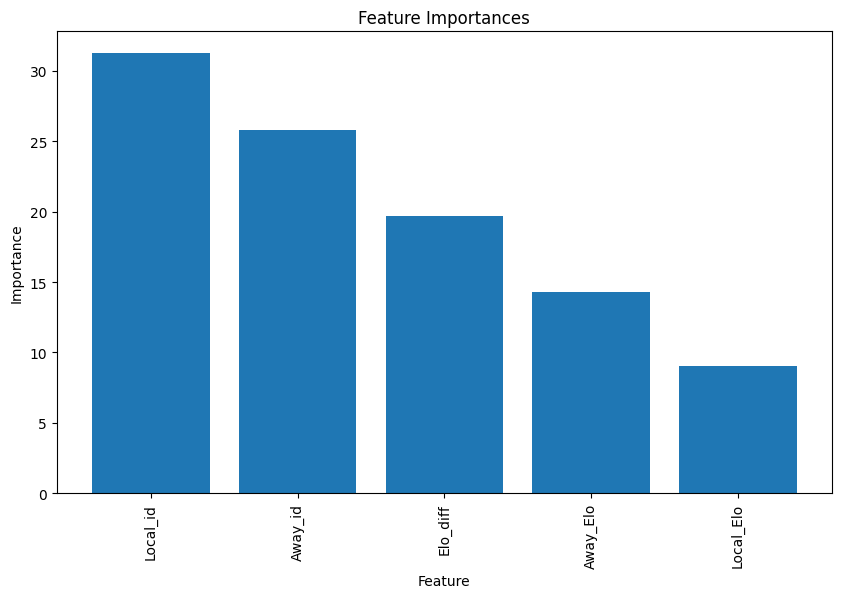

In [36]:
feature_importance = model.get_feature_importance()

# Get the names of features
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Sort feature importances in descending order
indices = feature_importance.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importance[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

In [24]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'learning_rate': [0.01, 0.1, 0.2],
              'depth': [4, 6, 8],
              'iterations': [100, 200, 300]}

# Perform grid search
grid_search = GridSearchCV(CatBoostClassifier(), param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_params

0:	learn: 1.0957105	total: 5.59ms	remaining: 554ms
1:	learn: 1.0928575	total: 11.9ms	remaining: 584ms
2:	learn: 1.0900525	total: 21.6ms	remaining: 700ms
3:	learn: 1.0874150	total: 26.8ms	remaining: 644ms
4:	learn: 1.0847968	total: 32.8ms	remaining: 624ms
5:	learn: 1.0822089	total: 37.9ms	remaining: 593ms
6:	learn: 1.0797356	total: 42ms	remaining: 558ms
7:	learn: 1.0771895	total: 45.9ms	remaining: 527ms
8:	learn: 1.0748168	total: 50ms	remaining: 506ms
9:	learn: 1.0724620	total: 54ms	remaining: 486ms
10:	learn: 1.0701439	total: 58.6ms	remaining: 474ms
11:	learn: 1.0678583	total: 62.7ms	remaining: 460ms
12:	learn: 1.0656332	total: 67.4ms	remaining: 451ms
13:	learn: 1.0634402	total: 72.7ms	remaining: 447ms
14:	learn: 1.0613007	total: 77.4ms	remaining: 438ms
15:	learn: 1.0592124	total: 81.9ms	remaining: 430ms
16:	learn: 1.0571687	total: 86.2ms	remaining: 421ms
17:	learn: 1.0552080	total: 91.1ms	remaining: 415ms
18:	learn: 1.0532316	total: 98.3ms	remaining: 419ms
19:	learn: 1.0513139	total: 

{'depth': 8, 'iterations': 300, 'learning_rate': 0.01}

In [14]:
seasons = '2010:2020'
first_season = seasons.split(':')[0] + '-' + str(int(seasons.split(':')[0]) + 1)
last_season = seasons.split(':')[1] + '-' + str(int(seasons.split(':')[1]) + 1)
print(first_season)
test_df = df[(df['season'] >= first_season)&(df['season'] <= last_season)]
test_df

2010-2011


,Unnamed: 0,season,division,matchday,date,time,home_team,away_team,score,local_score,away_score,results,results_encoded,goal_diff,abs_goal_diff,Local_Elo,Away_Elo,Elo_diff,Local_id,Away_id,Local_Rank,Away_Rank
21638,21638,2010-2011,1,1,8/28/10,6:00 PM,Hércules CF,Athletic,0:1,0,1,2,3,-1,1,978.398621,1063.721324,-85.322703,15,6,0,0
21639,21639,2010-2011,1,1,8/28/10,8:00 PM,Málaga CF,Valencia,1:3,1,3,2,3,-2,2,1016.265636,1166.276932,-150.011295,59,11,0,0
21640,21640,2010-2011,1,1,8/28/10,10:00 PM,Levante,Sevilla FC,1:4,1,4,2,3,-3,3,933.372421,1131.091838,-197.719418,44,14,0,0
21641,21641,2010-2011,1,1,8/29/10,5:00 PM,Espanyol,Getafe,3:1,3,1,1,1,2,2,1042.908648,1106.036887,-63.128239,1,61,0,0
21642,21642,2010-2011,1,1,8/29/10,5:00 PM,Real Sociedad,Villarreal,1:0,1,0,1,1,1,1,1010.214446,1130.466960,-120.252515,24,58,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47933,47933,2020-2021,2,42,5/30/21,9:00 PM,CD Mirandés,CE Sabadell,0:2,0,2,2,3,-2,2,1017.006865,973.987360,43.019505,140,26,0,0
47934,47934,2020-2021,2,42,5/30/21,9:00 PM,Ponferradina,RCD Mallorca,2:2,2,2,X,2,0,0,1011.181594,1121.720197,-110.538603,132,40,0,0
47935,47935,2020-2021,2,42,5/30/21,9:00 PM,Rayo Vallecano,CD Lugo,0:1,0,1,2,3,-1,1,1093.656060,987.482594,106.173467,49,118,0,0
47936,47936,2020-2021,2,42,5/30/21,9:00 PM,Real Zaragoza,CD Leganés,0:5,0,5,2,3,-5,5,1032.255797,1100.092564,-67.836766,17,65,0,0
